In [292]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [293]:
# Specify the directory path
directory_path = 'datasets/RIPEAtlas/02072023/coords/'

# Iterate over all files in the directory
coord_dict = {}
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    file = os.path.join(directory_path, filename)
    if os.path.isfile(file):
        df = topology.coords_ripe_atlas(file)
        
        coords = df[["x", "y"]].to_numpy()
        c_coords = coords[0]
        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
        f = filename.replace(".csv", "")
        f = int(f.replace("time-", ""))
        coord_dict[f] = df
        
coord_list = []
for i in sorted(coord_dict.keys()):
    coord_list.append(coord_dict[i])
        

t_label = 0
coords_df = coord_dict[t_label]
s_dict = {t_label: coords_df}
avg = 50
c_capacity = 50
seed = 10
H, bins = get_lognorm_hist()

device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(s_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=seed)
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
num_clusters = prim_df["cluster"].nunique() - 1
prim_df

Creating df for 0
Optimal k is 10
Done


,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1
0,-75.830277,52.683942,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1,1
1,-42.265554,59.965194,34.345411,worker,9223372036854775807,3,50,50,46,55,42,53,48,30,36,117,52,12,1,1
2,-68.493981,9.120721,44.176640,worker,9223372036854775807,3,50,50,52,46,51,43,36,58,32,65,71,24,1,1
3,-99.443849,25.313260,36.149067,worker,9223372036854775807,2,50,53,53,48,64,44,64,63,39,18,55,12,1,1
4,-94.569935,-10.751235,66.145268,worker,9223372036854775807,29,50,53,48,48,49,47,35,61,47,24,19,62,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,-129.978419,32.805344,57.681712,worker,9223372036854775807,1,50,49,53,53,44,38,58,71,90,53,39,93,7,1
627,184.342454,203.354003,300.651489,worker,9223372036854775807,3,50,48,45,42,63,47,37,49,33,27,42,28,9,1
628,-11.243729,216.694522,176.269375,worker,9223372036854775807,1,50,52,53,44,53,70,55,61,29,26,21,0,2,1
629,178.467782,231.397961,310.815385,worker,9223372036854775807,4,50,52,54,51,47,53,33,72,31,87,19,16,9,1


In [294]:
coord_dict.keys()

dict_keys([16, 8, 0, 2, 18, 22, 14, 4, 11, 21, 20, 1, 3, 9, 17, 13, 15, 5, 12, 19, 10, 23, 6, 7])

In [295]:
coord_dict[t_label]

,x,y,latency
0,-75.830277,52.683942,0.000000
1,-42.265554,59.965194,34.345411
2,-68.493981,9.120721,44.176640
3,-99.443849,25.313260,36.149067
4,-94.569935,-10.751235,66.145268
...,...,...,...
626,-129.978419,32.805344,57.681712
627,184.342454,203.354003,300.651489
628,-11.243729,216.694522,176.269375
629,178.467782,231.397961,310.815385


In [296]:
coord_dict[t_label]

,x,y,latency
0,-75.830277,52.683942,0.000000
1,-42.265554,59.965194,34.345411
2,-68.493981,9.120721,44.176640
3,-99.443849,25.313260,36.149067
4,-94.569935,-10.751235,66.145268
...,...,...,...
626,-129.978419,32.805344,57.681712
627,184.342454,203.354003,300.651489
628,-11.243729,216.694522,176.269375
629,178.467782,231.397961,310.815385


In [297]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 4033 Available: 31550


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

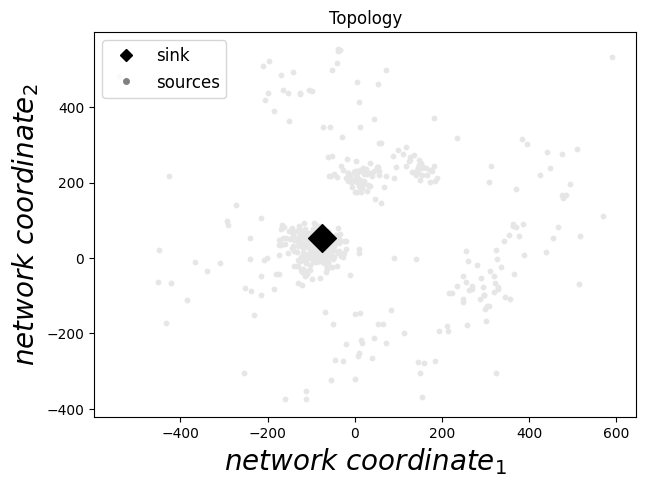

In [298]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

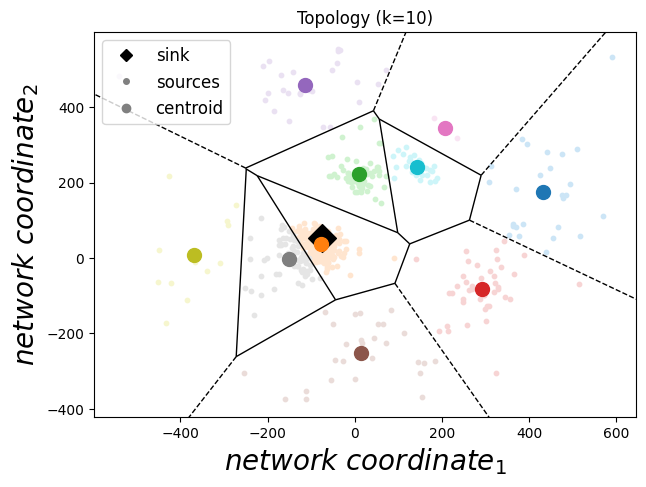

In [299]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Changing Topology

In [300]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.1},
    "weight_2": {"merge_factor": 0.9, "step_size": 0.2},
    "weight": {"merge_factor": 0.4, "step_size": 0.4},
}

In [301]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"

evaluations = []
evaluations_full = []
placement_df = None

for i, coords_df in enumerate(coord_list):
    df = prim_df.copy()
    df["x"] = coords_df["x"]
    df["y"] = coords_df["y"]
    df["latency"] = coords_df["latency"]
    df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)
    
    eval_matrix, df_dict, opt_dict, limits_dict = evaluate_nemo(df, [slot_col], weight_col,
                                               merge_factor=param_dict[weight_col][
                                                   "merge_factor"],
                                               step_size=param_dict[weight_col]["step_size"],
                                               with_eval=True)
    if i == 0:
        placement_df = df_dict[slot_col].copy()
    
    if limits_dict[slot_col] == True:
        break
    
    evaluations_full.append(eval_matrix[slot_col])
    
    if i > 0:
        update_df = coords_df[["x", "y"]]
        df = util.update_coordinates(placement_df, update_df)
        edf = evaluate(df)
    else:
        edf = eval_matrix[slot_col]
    evaluations.append(edf)

Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  21
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.1, merge_factor=0.1
Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  20
Evaluating for capacity_100
Optimal k is 10
Starting nemo fo

In [302]:
df

,oindex,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load,x,y
0,0,coordinator,-1,<NA>,<NA>,<NA>,50,29,2,<NA>,21,734.277871,518.400034
1,1,worker,1,1,0,1,50,50,0,433,0,714.440361,553.066465
2,2,worker,1,1,0,1,50,50,0,221,0,709.309142,577.841507
3,3,worker,1,1,0,1,50,50,0,121,0,699.768610,559.238788
4,4,worker,1,1,0,1,50,50,0,508,0,694.736824,534.184741
...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,626,worker,7,1,0,1,50,50,0,109,0,727.732891,523.839020
627,627,worker,9,1,0,1,50,50,0,489,0,985.099485,480.211289
628,628,worker,2,1,0,1,50,50,0,467,0,863.721148,656.186229
629,629,worker,9,1,0,1,50,50,0,489,0,1025.317412,487.424013


In [303]:
s = 3
evaluations[s].sort_index()

,latency_distribution,received_packets
0,0.000000,21.0
1,84.667264,0.0
2,94.968759,0.0
3,115.405141,0.0
4,100.247336,0.0
...,...,...
626,71.473539,0.0
627,415.957755,0.0
628,272.839691,0.0
629,442.693832,0.0


In [304]:
evaluations_full[s].sort_index()

,latency_distribution,received_packets
0,0.000000,20.0
1,80.193863,0.0
2,59.491919,0.0
3,103.265962,0.0
4,99.837810,0.0
...,...,...
626,86.319952,0.0
627,404.821570,0.0
628,255.137770,0.0
629,409.874193,0.0


## Evaluation

#### Latency

In [305]:
colors, light_colors, palette = util.get_color_list(11)

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


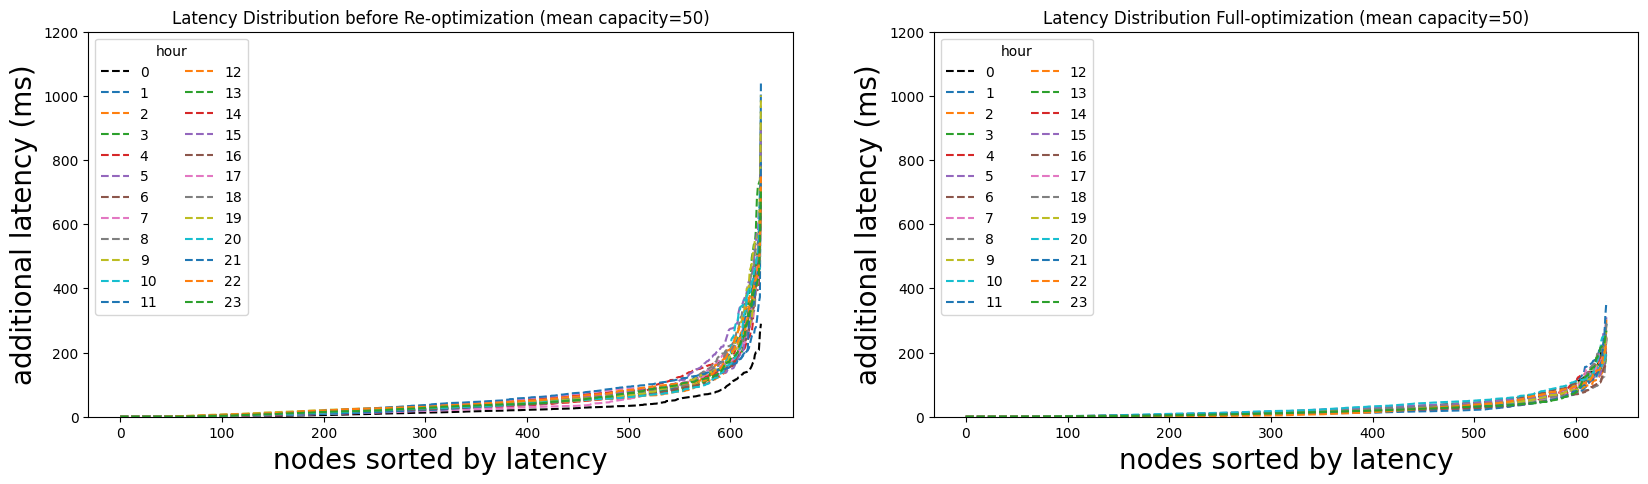

In [306]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
quant_dict = {}
mean_dict = {}
prim_eval = coord_dict[t_label]["latency"]
nodes_take = 50
changed_nodes = {}

for i in range(len(evaluations)):
    l = str(i)
    sv1 = evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")
        
    sv1 = evaluations_full[i].sort_index()["latency_distribution"]
    sv = sv1 - sv2
    sv = sv.sort_values()
    
    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:]) # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")

ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('additional latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.set_ylim([0, 1200])
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()
ax2.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution before Re-optimization (mean capacity=' + str(avg) + ")")
ax2.set_title('Latency Distribution Full-optimization (mean capacity=' + str(avg) + ")")
plt.show()

## Test Reoptimization

In [381]:
i = 0
ndf = prim_df.copy()
ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]
ndf["latency"] = coord_list[i]["latency"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
evaluations[i] = edf
print(df["oindex"].nunique())
df

Level 0 CH number:  630
--------Balancing load for 10 clusters to 0
Clusters processed: 0
Level 1 CH number:  21
631


,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,-75.830277,52.683942,coordinator,-1,<NA>,<NA>,<NA>,50,29,2,<NA>,21
1,1,-42.265554,59.965194,worker,1,1,0,1,50,50,0,433,0
2,2,-68.493981,9.120721,worker,1,1,0,1,50,50,0,221,0
3,3,-99.443849,25.313260,worker,1,1,0,1,50,50,0,121,0
4,4,-94.569935,-10.751235,worker,1,1,0,1,50,50,0,508,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,626,-129.978419,32.805344,worker,7,1,0,1,50,50,0,109,0
627,627,184.342454,203.354003,worker,9,1,0,1,50,50,0,489,0
628,628,-11.243729,216.694522,worker,2,1,0,1,50,50,0,467,0
629,629,178.467782,231.397961,worker,9,1,0,1,50,50,0,489,0


In [382]:
re_evaluations = [evaluations[0]]
k_neigh = 400
df_re = df
root_df = coord_list[0]

for i in range(1, len(evaluations)):
    nodes = changed_nodes[i]
    nodes = set(nodes).intersection(df_re["oindex"].unique())
    nodes = list(nodes)
    print("Iteration", i, "Nodes", nodes)
    update_df, centroids, opt_k, sil = topology.add_kmeans_labels(coord_list[i], kmin=num_clusters, kmax=num_clusters, kseed=seed)
    nemo.update_coordinates(update_df)
    df_re, opt_dict, resource_limit, level = nemo.remove_nodes(nodes, step_size=0.1, merge_factor=0.3)
    
    new_nodes = list()
    for node_idx in nodes:
        node = prim_df.loc[node_idx].to_dict()
        new_distances_df = coord_list[i]
        #n_coords, error = util.fit_coords(node_idx, root_df, new_distances_df, k_neigh)
        node["x"] = coord_list[i].loc[node_idx, "x"] #n_coords[0]
        node["y"] = coord_list[i].loc[node_idx, "y"] #n_coords[1]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node["oindex"] = node_idx
        new_nodes.append(node)
        # new_idx, df_re, resource_limit = nemo.add_node(node)
    df_re, opt_dict, resource_limit, level = nemo.add_nodes(new_nodes, full_opt=True, k_cluster_opt=4)
    if resource_limit:
        print("----------------Resource limit reached. Init full opt")
        df = prim_df.copy()
        coords_df = coord_list[i]
        
        df["x"] = coords_df["x"]
        df["y"] = coords_df["y"]
        df["latency"] = coords_df["latency"]
        df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)
        
        nemo = NemoSolver(df, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                      merge_factor=param_dict[weight_col]["merge_factor"])
        df_re, opts, resource_limit = nemo.nemo_full()
        
        if resource_limit:
            print("Resource Limit!!!!!!!!!")
            break
    
    update_df = coord_list[i][["x", "y"]]
    df = util.update_coordinates(df_re, update_df)
    edf = evaluate(df)
    re_evaluations.append(edf)

Iteration 1 Nodes [259, 6, 135, 393, 396, 141, 528, 274, 21, 533, 407, 280, 153, 26, 29, 285, 287, 413, 416, 291, 164, 294, 167, 303, 437, 310, 311, 566, 316, 572, 446, 447, 193, 578, 452, 326, 199, 582, 206, 81, 84, 90, 219, 223, 226, 486, 233, 490, 492, 114]
Optimal k is 10
Node with ID [528, 26, 291, 486] are cluster head. Re-optimizing children with level 0: {0: [515, 541, 94, 151, 278, 302, 357, 398, 399, 400, 401, 469], 3: [517, 519, 527, 20, 535, 538, 545, 580, 73, 586, 595, 620, 127, 139, 142, 154, 192, 203, 207, 217, 232, 306, 339, 384, 402, 403, 429, 442, 451, 460, 463, 477, 478, 480, 501, 511], 4: [7, 611, 502, 503], 5: [386], 6: [514, 13, 579, 600, 606, 195, 286, 292, 293, 295, 296, 297, 298, 321, 352, 419, 424, 450], 7: [49, 208, 381, 418, 449, 462, 493], 9: [380]}
Level 0 CH number:  79
--------Balancing load for 7 clusters to 0
Clusters processed: 0
Level 1 CH number:  7
re-optimizing clusters dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Level 0 CH number:  630
--------Bala

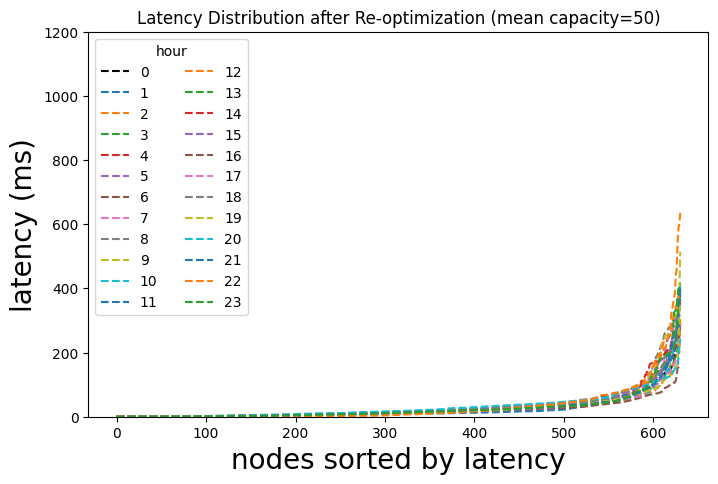

Means:  {'0': 25.35, '1': 26.35, '2': 22.61, '3': 26.12, '4': 24.22, '5': 30.88, '6': 29.73, '7': 25.81, '8': 32.4, '9': 32.25, '10': 25.79, '11': 22.17, '12': 32.57, '13': 29.89, '14': 29.64, '15': 31.34, '16': 18.9, '17': 23.28, '18': 28.89, '19': 23.28, '20': 29.79, '21': 26.29, '22': 32.17, '23': 27.2}
Quantiles:  {'0': 64.49, '1': 62.61, '2': 53.03, '3': 72.28, '4': 64.44, '5': 66.48, '6': 75.6, '7': 63.86, '8': 80.28, '9': 70.57, '10': 55.31, '11': 66.51, '12': 74.91, '13': 60.05, '14': 59.71, '15': 73.58, '16': 46.21, '17': 54.04, '18': 59.68, '19': 59.79, '20': 80.75, '21': 58.11, '22': 81.64, '23': 53.07}


In [383]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i in range(len(re_evaluations)):
    l = str(i)
    sv1 = re_evaluations[i].sort_index()["latency_distribution"]
    sv2 = coord_list[i].sort_index()["latency"]
    sv = (sv1 - sv2).dropna()
    sv = sv.sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv = sv.to_numpy()

    if i == 0:
        ax1.plot(sv, label=l, linestyle="--", color="black")
    else:
        ax1.plot(sv, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution after Re-optimization (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)